In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config

import pandas as pd
import numpy as np
from ipyfilechooser import FileChooser
import glob
import os


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


In [3]:
# choose a folder
fchooser = FileChooser(os.path.join(os.getcwd(),'exp/cv_baseline_taug18'), '')
display(fchooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline_taug18', filename='', title='HTML(value='', …

In [4]:
fchooser.selected
all_pred_files = sorted(glob.glob('{}/**/*.npy'.format(fchooser.selected), recursive=True))

In [5]:
print(len(all_pred_files))
all_pred_files

4


['/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline_taug18/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotbrigthness_taug3_3_batch8_f0/2021-03-03_16_12/pred/gtpred_fold0.npy',
 '/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline_taug18/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotbrigthness_taug3_3_batch8_f1/2021-03-03_17_26/pred/gtpred_fold1.npy',
 '/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline_taug18/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotbrigthness_taug3_3_batch8_f2/2021-03-03_17_56/pred/gtpred_fold2.npy',
 '/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline_taug18/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotbrigthness_taug3_3_batch8_f3/2021-03-03_18_26/pred/gtpred_fold3.npy']

In [6]:
# Load the numpy files
preds = list(map(lambda x : np.load(x), all_pred_files))

In [7]:
# stack the numpy files
preds = np.concatenate(preds, axis=1)
print(preds.shape)

(2, 278, 2, 36, 5)


In [8]:
# calculate the mean differences
from src.utils.Metrics import meandiff
res = meandiff(preds[0], preds[1], apply_sum=False, apply_average=False)
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
df = pd.DataFrame(res.numpy(), columns=phases)
df.shape

(278, 5)

# Error per Phase

In [9]:
print('Mean per phase: \n{}'.format(df.mean(axis=0)))
print('Median per phase: \n{}'.format(df.median(axis=0)))
print('Std per phase: \n{}'.format(df.std(axis=0)))

print('Mean overall: \n{}'.format(df.values.mean()))
print('Median overall: \n{}'.format(np.median(df.values)))
print('Std overall: \n{}'.format(df.values.std()))

Mean per phase: 
ED    0.776978
MS    0.694245
ES    0.669065
PF    0.607914
MD    1.082734
dtype: float64
Median per phase: 
ED    1.0
MS    1.0
ES    1.0
PF    0.0
MD    1.0
dtype: float64
Std per phase: 
ED    0.923368
MS    0.723536
ES    0.865617
PF    0.731604
MD    1.326074
dtype: float64
Mean overall: 
0.7661870503597122
Median overall: 
1.0
Std overall: 
0.9532265507729492


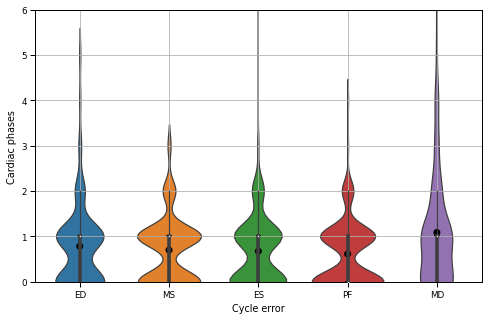

In [10]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(8,5))
ax = f.gca()
ax.set_ylim(bottom=0, top=6)
ax.set_ylabel('Cardiac phases')
ax.set_xlabel('Cycle error')
#_ = DF_METADATA[phases].plot(kind='violin'),
sb.violinplot(data=df, orient='v', ax = ax)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.median,color="black", markers="_", ci=None,join=False)
plt.grid()
plt.show()

# Error per cardiac cycle

In [30]:
df.median(axis=1)

0      1.0
1      2.0
2      1.0
3      1.0
4      0.0
      ... 
273    1.0
274    1.0
275    0.0
276    1.0
277    0.0
Length: 278, dtype: float64

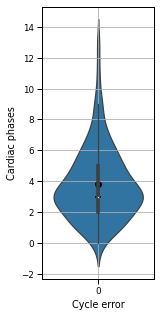

In [23]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(2,5))
ax = f.gca()
ax.set_ylabel('Cardiac phases')
ax.set_xlabel('Cycle error')
temp = df.sum(axis=1)
sb.violinplot(data=temp, orient='v', ax = ax)
#sb.scatterplot(data=temp, ax=ax)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.median,color="black", markers="_", ci=None,join=False)
plt.grid()
plt.show()